# **Match Experimental Data**

We try to match the behavior of the fish to observed experimental data by changing the logic and parameters for turning. The turning angles of the fish need to match some observed distribution rather than being a static number.

# Imports

In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import brightfish
import brightfish.environment as environment
import brightfish.fish as fish

# Experimental Data

First, we need to load and plot the given experimental data.

In [14]:
turning_distributions = pickle.load(open('turning_distributions.dat', 'rb'))
print(turning_distributions.keys())

dict_keys(['no_error', 'high_error'])


The data consists of two observed distributions of turning angles when the fish is at no error (neither eye sees any difference from the set point) and when the fish is at high error (observing a brightness far from its set point \[0.75\]). The recorded high error data is for when the fish turns to the left only (meaning the error in the left is low and the error in the right is high), so to get the high error turn distribution for turning right we can simply flip the distribution. Here, a negative degree value represents a left turn and a positive degree value represents a right turn. We can plot these distributions:

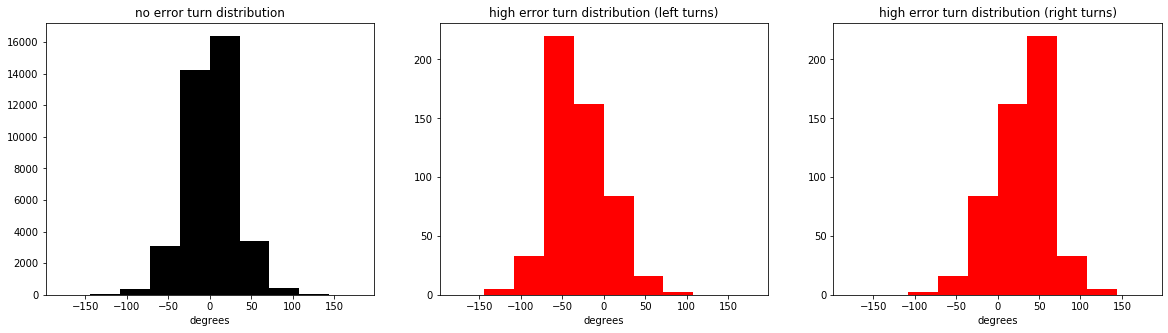

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax = axes[0]
ax.hist(turning_distributions['no_error'], color='black', range=(-180, 180))
ax.set_xlabel('degrees')
ax.set_title('no error turn distribution')

ax = axes[1]
ax.hist(turning_distributions['high_error'], color='red', range=(-180, 180))
ax.set_xlabel('degrees')
ax.set_title('high error turn distribution (left turns)')

ax = axes[2]
ax.hist(-1 * np.array(turning_distributions['high_error']), color='red', range=(-180, 180))
ax.set_xlabel('degrees')
ax.set_title('high error turn distribution (right turns)')

plt.show()

We can model these distributions as three Normal distributions. We can calculate a turn angle as a weighted combination of samples from the low error distribution and a corresponding , where the weighting is determined by distance from the set point. We plot these distributions below, converting to radians in the range \[0, 2$\pi$\]. A left turn now refers to a counterclockwise turn, and a right turn refers to a clockwise turn. We orient our direction to the unit circle, meaning 0 radians or 2$\pi$ radians points to the right on a 2D grid. Therefore, turning left (counterclockwise) moves by positive radians and turning right (clockwise) moves by negative radians. This is why the distributions look flipped.

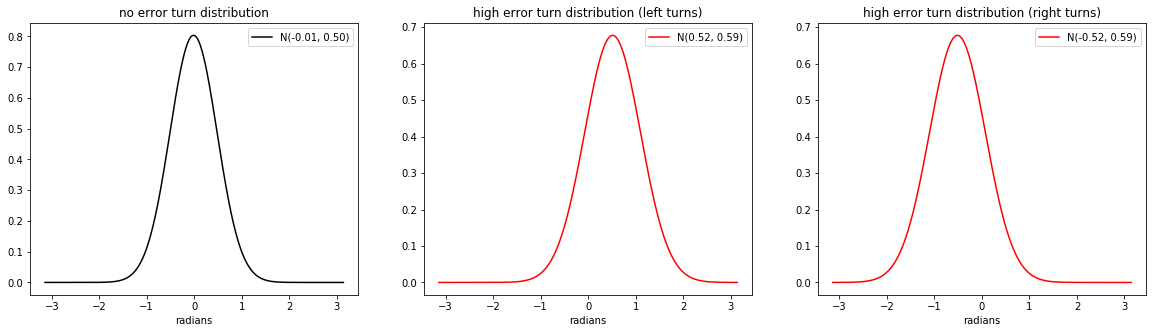

In [49]:
radians = np.linspace(-np.pi, np.pi, num=360, endpoint=True)

def normal_pdf(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))
            * np.exp(-(x - mu)**2 / (2 * sigma**2)))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax = axes[0]
mu = np.radians(np.mean(-np.array(turning_distributions['no_error'])))
sigma = np.radians(np.std(-np.array(turning_distributions['no_error'])))
ax.plot(radians, normal_pdf(radians, mu, sigma), label=f"N({mu:.2f}, {sigma:.2f})", color='black')
ax.set_xlabel('radians')
ax.set_title('no error turn distribution')
ax.legend()

ax = axes[1]
mu = np.radians(np.mean(-np.array(turning_distributions['high_error'])))
sigma = np.radians(np.std(-np.array(turning_distributions['high_error'])))
ax.plot(radians, normal_pdf(radians, mu, sigma), label=f"N({mu:.2f}, {sigma:.2f})", color='red')
ax.set_xlabel('radians')
ax.set_title('high error turn distribution (left turns)')
ax.legend()

ax = axes[2]
mu = np.radians(np.mean(turning_distributions['high_error']))
sigma = np.radians(np.std(turning_distributions['high_error']))
ax.plot(radians, normal_pdf(radians, mu, sigma), label=f"N({mu:.2f}, {sigma:.2f})", color='red')
ax.set_xlabel('radians')
ax.set_title('high error turn distribution (right turns)')
ax.legend()

plt.show()

# Sinusoidal Environment

First, we'll need to create an environment for the fish to operate in. We'll use the simple 1D sinusoidal environment for now:

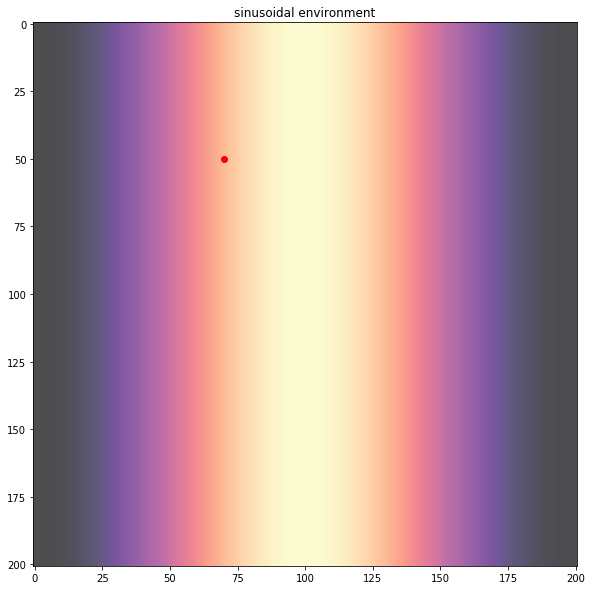

In [2]:
e = environment.SinusoidalGradient((201, 201), static=True)
fig = plt.figure(figsize=(10, 10))
plt.imshow(e.stage, cmap='magma', alpha=0.7)
plt.scatter([70], [50], c='r')
plt.title("sinusoidal environment")
plt.show()

Next, we'll have to create a (binocular) fish:

In [3]:
f = fish.BinocularFish(np.pi/4, [50, 70], turning_cap=0.5, turning_rate=5e-2, p_move=0.2, move_distance=5.0)
print(f)

BinocularFish: heading: 0.79 position: [50, 70] set_point: 0.50 p_left: 0.33 p_right: 0.33


Now that we have a fish, we can allow the fish to simulate some time in the environment and observe the change in parameters:

In [6]:
timesteps = 1000
params = f.run(e, timesteps)

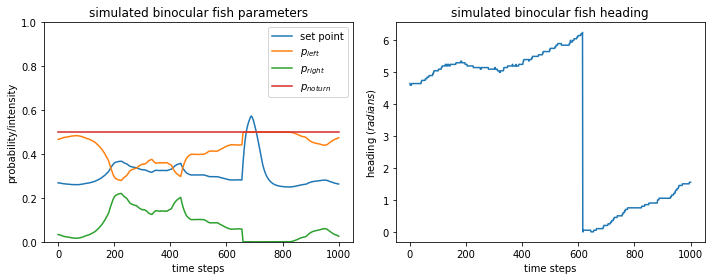

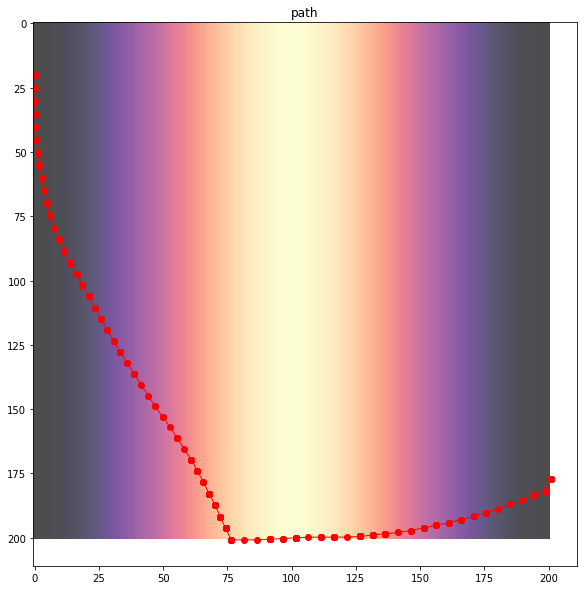

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.arange(timesteps+1), params[:,3], label="set point")
axs[0].plot(np.arange(timesteps+1), params[:,4], label=r"$p_{left}$")
axs[0].plot(np.arange(timesteps+1), params[:,5], label=r"$p_{right}$")
axs[0].plot(np.arange(timesteps+1), params[:,6], label=r"$p_{noturn}$")
axs[0].set_ylim(0, 1.0)
axs[0].set_title("simulated binocular fish parameters")
axs[0].set_xlabel("time steps")
axs[0].set_ylabel("probability/intensity")
axs[0].legend()
axs[1].plot(np.arange(timesteps+1), params[:,0], label="heading")
axs[1].set_title("simulated binocular fish heading")
axs[1].set_xlabel("time steps")
axs[1].set_ylabel(r"heading ($radians$)")
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 10))
plt.imshow(e.stage, cmap='magma', alpha=0.7)
plt.plot(params[:,2], params[:,1], marker='o', color='r', linewidth=1.0)
plt.title("path")
plt.show()

We can also create a monocular fish and observe the difference in behavior:

In [9]:
f = fish.MonocularFish(np.pi/4, [50, 70], turning_cap=0.5, turning_rate=5e-2, p_move=0.2, move_distance=5.0)
print(f)

MonocularFish: heading: 0.79 position: [50, 70] set_point_left: 0.50 set_point_right: 0.50 p_left: 0.33 p_right: 0.33


In [10]:
timesteps = 1000
params = f.run(e, timesteps)

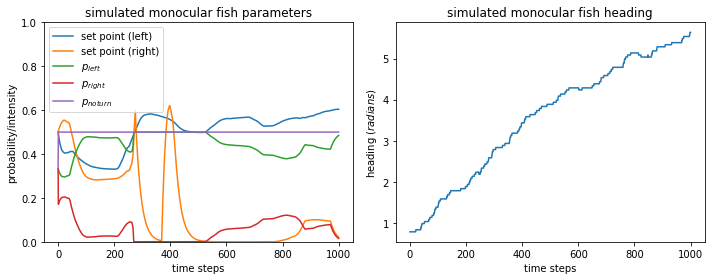

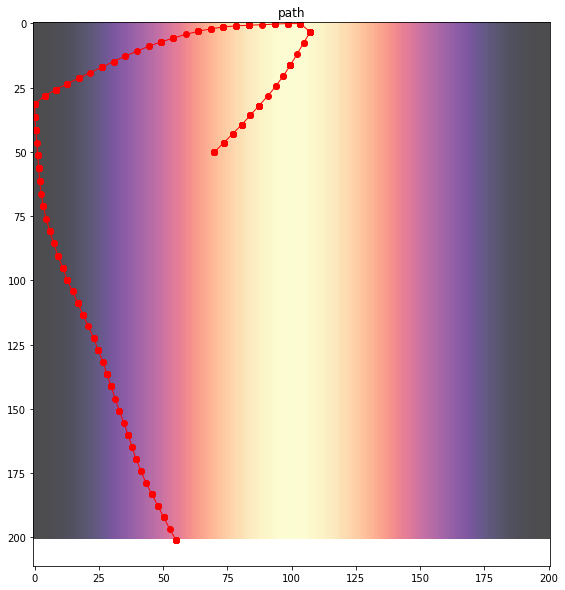

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.arange(timesteps+1), params[:,3], label="set point (left)")
axs[0].plot(np.arange(timesteps+1), params[:,4], label="set point (right)")
axs[0].plot(np.arange(timesteps+1), params[:,5], label=r"$p_{left}$")
axs[0].plot(np.arange(timesteps+1), params[:,6], label=r"$p_{right}$")
axs[0].plot(np.arange(timesteps+1), params[:,7], label=r"$p_{noturn}$")
axs[0].set_ylim(0, 1.0)
axs[0].set_title("simulated monocular fish parameters")
axs[0].set_xlabel("time steps")
axs[0].set_ylabel("probability/intensity")
axs[0].legend()
axs[1].plot(np.arange(timesteps+1), params[:,0], label="heading")
axs[1].set_title("simulated monocular fish heading")
axs[1].set_xlabel("time steps")
axs[1].set_ylabel(r"heading ($radians$)")
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 10))
plt.imshow(e.stage, cmap='magma', alpha=0.7)
plt.plot(params[:,2], params[:,1], marker='o', color='r', linewidth=1.0)
plt.title("path")
plt.show()